In [1]:
import numpy as np
from theforce.radial_funcs import quadratic_cutoff as radial
from theforce.sesoap import SeSoap
import torch
from torch.autograd import Function


lmax, nmax, rc = 4, 4, 3.
NumpySoap = SeSoap(lmax, nmax, radial(rc))


class TorchSoap(Function):

    @staticmethod
    def forward(ctx, xyz):
        _p, _q = NumpySoap.derivatives(xyz.detach().numpy(), sumj=False)
        p = torch.as_tensor(_p)
        q = torch.as_tensor(_q)
        ctx.save_for_backward(q)
        return p

    @staticmethod
    def backward(ctx, grad_output):
        q, = ctx.saved_tensors
        grad = torch.einsum('i,i...->i...', grad_output, q)
        return grad


soap = TorchSoap.apply


sym = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1.]])
ref = torch.as_tensor(sym)
pref = soap(ref)


xyz = torch.rand(ref.size(), requires_grad=True, dtype=ref.dtype) # <- dtype only here
optimizer = torch.optim.Adam([xyz], lr=0.1)
training = []
for i in range(100):
    def closure():
        global training
        optimizer.zero_grad()
        p = soap(xyz)
        loss = ((p - pref)**2).sum() 
        loss.backward()
        training += [loss.data]
        return loss
    optimizer.step(closure)
    
    
print(torch.einsum('ij,kj->ik', ref, ref))
print(torch.einsum('ij,kj->ik', xyz, xyz))

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)
tensor([[ 1.0122,  0.1019, -0.0331],
        [ 0.1019,  0.9943, -0.0663],
        [-0.0331, -0.0663,  0.9953]], dtype=torch.float64,
       grad_fn=<AsStridedBackward>)


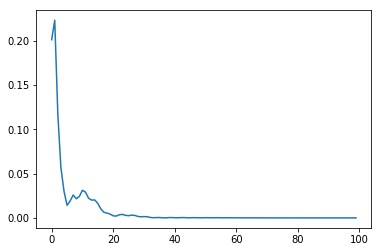

In [2]:
import pylab as plt
%matplotlib inline
plt.plot(training)